### This has been done as a project under [Coursera.org](https://www.coursera.org/learn/classify-radio-signals-space-keras-cnn/home/welcome) to help implement CNN classification using Keras on outer Space datasets.

Datasets from Allen Telescope Array has been used for this classfication. 
[Allen Telescope Array](https://flickr.com/photos/93452909@N00/5656086917) by [brewbooks](https://www.flickr.com/people/93452909@N00) is licensed under [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/)


In [10]:
from livelossplot.tf_keras import PlotLossesCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)
import warnings;warnings.simplefilter('ignore')
%matplotlib inline
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.4.0


## Radio Signals information from SETI datasets are used in this classification method.

In [3]:
train_images = pd.read_csv('dataset/train/images.csv', header=None)
val_images = pd.read_csv('dataset/validation/images.csv', header=None)

train_labels = pd.read_csv('dataset/train/labels.csv', header=None)
val_labels = pd.read_csv('dataset/validation/labels.csv', header=None)

In [4]:
train_images.head(3)

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510


In [5]:
train_labels.head(3)

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0


In [6]:
print("Training set shape: ", train_images.shape, train_labels.shape)
print("Validation set shape: ", val_images.shape, val_labels.shape)

Training set shape:  (3200, 8192) (3200, 4)
Validation set shape:  (800, 8192) (800, 4)


In [7]:
x_train = train_images.values.reshape(3200,64,128, 1)
x_val = val_images.values.reshape(800,64,128, 1)

y_train= train_labels.values
y_val = val_labels.values

## I plotted 2D Spectrograms to get a comparison ground for the CNN

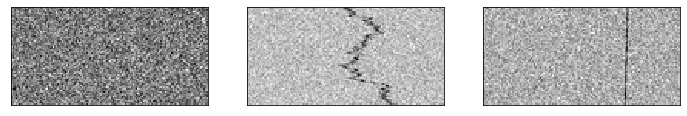

In [16]:
plt.figure(0,figsize=(12,12))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = np.squeeze(x_train[np.random.randint(0,x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray")

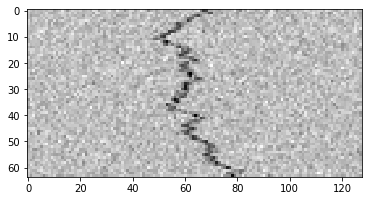

In [15]:
plt.imshow(np.squeeze(x_train[3]), cmap="gray")

## Training + Validation Data Generators are created

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train=ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)
datagen_val = ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_val)

## The CNN model is developed after importing the utilities of the model

In [22]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [23]:
# Initialising the CNN
#sequential model from keras
#first takes inpput from input layer, performs convolution and nonlinearity is added using relu
#after that, maxpooling
#repeats in conv layer 2

model = Sequential()


# 1st Convolution kerbel size of 5x5; need 32 feature maps/filters on each image
model.add(Conv2D(32,(5,5), padding="same", input_shape=(64,128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
          
# 2nd Convolution layer
model.add(Conv2D(64, (5,5), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())
# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
#no maxpooling as no convolutions
#a lot of neurones, so more regularization dropout higher
model.add(Dropout(0.4))
#to give me values between zero and one
model.add(Dense(4, activation='softmax'))

## Scheduled the learning rate and compiled model

In [26]:
initial_learning = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = initial_learning,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)

In [27]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 128, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64, 64)        2

## Train the model

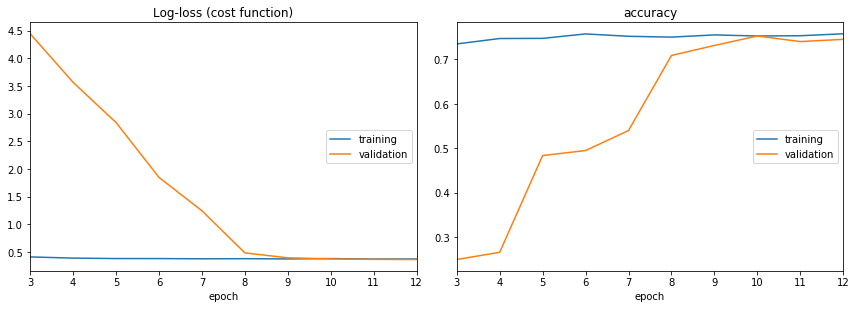

Log-loss (cost function):
training   (min:    0.374, max:    0.677, cur:    0.376)
validation (min:    0.366, max:    4.444, cur:    0.366)

accuracy:
training   (min:    0.677, max:    0.757, cur:    0.757)
validation (min:    0.250, max:    0.752, cur:    0.745)
100/100 [==============================] - 6s 57ms/step - loss: 0.3757 - accuracy: 0.7575 - val_loss: 0.3656 - val_accuracy: 0.7450


In [32]:
checkpoint = ModelCheckpoint('model_weight.h5',monitor='val_loss',save_weights_only=True, mode='min', verbose=0)
callbacks= [PlotLossesCallback(), checkpoint]
batch_size = 32
history=model.fit(
    datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
    steps_per_epoch=len(x_train) // batch_size,
    validation_data=datagen_val.flow(x_val,y_val, batch_size, shuffle=True),
    validation_steps= len(x_val)//batch_size,
    epochs=12, 
    callbacks=callbacks
)

## Evaluate the model

In [34]:
model.evaluate(x_val, y_val)

800/800 [==============================] - 1s 717us/sample - loss: 0.3659 - accuracy: 0.7538


[0.3658542043669149, 0.75375]

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns



In [36]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]
y_true=np.argmax(y_val, 1)
y_pred= np.argmax(model.predict(x_val),1)
print(metrics.classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       200
           1       0.51      0.68      0.58       200
           2       0.51      0.35      0.42       200
           3       1.00      1.00      1.00       200

    accuracy                           0.75       800
   macro avg       0.76      0.75      0.75       800
weighted avg       0.76      0.75      0.75       800



In [ ]:
print('Classification accuracy: %0.6f')